<a href="https://colab.research.google.com/github/bingsen-wang/EE-Fundamentals/blob/main/Piano_ADSR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><b>Fundamental Frequencies of Piano with ADSR Envelope</h1></b>

Dr. Bingsen Wang

12/6/2023
</center>

#Python Code
The Python code generates the sound of varies waveforms.  

Moviepy - Building video PianoADSRsound.mp4.
MoviePy - Writing audio in PianoADSRsoundTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video PianoADSRsound.mp4



Moviepy - Done !
Moviepy - video ready PianoADSRsound.mp4


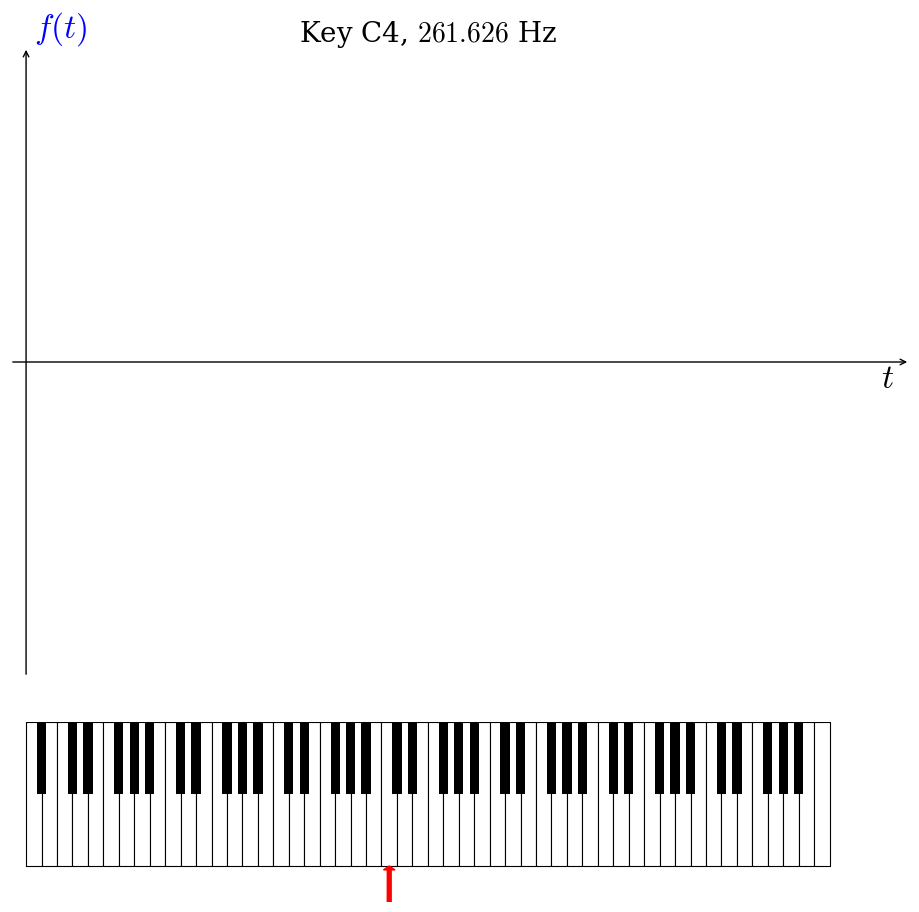

In [42]:
from logging import WARNING
from os import linesep
import matplotlib
from scipy.io.wavfile import write
from moviepy.editor import *
from numpy import linspace,cos,pi,sin,arccos,fft,angle,abs,clip,int16,array,heaviside
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib import animation,rc
rc('animation', html='jshtml')
plt.rcParams.update({"font.family" : "serif","mathtext.fontset" : "cm"})

def adsr(t,*args):
  T_total,a1,a2,a3,d1,d2,d3=args
  t1 = d1*T_total
  t2 = t1+d2*T_total
  t3 = t2+d3*T_total
  t4 = T_total
  at = a1/t1*t*(heaviside(t,0)-heaviside(t-t1,0)) #attack
  if t1==t2:
    dt=0
  else:
    dt = ((a2-a1)/(t2-t1)*(t-t1)+a1)*(heaviside(t-t1,0)-heaviside(t-t2,0)) #decay
  if t2==t3:
    st=0
  else:
    st = ((a3-a2)/(t3-t2)*(t-t2)+a2)*(heaviside(t-t2,0)-heaviside(t-t3,0)) #sustain
  if t3==t4:
    rt=0
  else:
    rt = (-a3/(t4-t3)*(t-t3)+a3)*(heaviside(t-t3,0)-heaviside(t-t4,0)) #release
  return at+dt+st+rt

def x(f,t,*args):
  return adsr(t,*args)*sin(2*pi*f*t)

def layout_88keys(ax):
  kww = 1/52 #key width for white keys
  kwb = 1/52*0.6 #key width for white keys
  whiteKeys = []
  for i in range(52): #52 white keys
      whiteKeys.append(Rectangle((i*kww, 0.2), kww ,0.8 ))
  blackKeys = []
  for i in range(36): #36 black keys
    ii=i%5
    k=int(i/5)
    if ii<1:
      blackKeys.append(Rectangle(((ii+1+k*7)*kww - .5*kwb, 0.6), kwb ,0.4 ))
    elif ii<3:
      blackKeys.append(Rectangle(((ii+2+k*7)*kww - .5*kwb, 0.6), kwb ,0.4 ))
    else:
      blackKeys.append(Rectangle(((ii+3+k*7)*kww - .5*kwb, 0.6), kwb ,0.4 ))
  pc1 = PatchCollection(whiteKeys, facecolor='w',edgecolor='k',lw=0.8)
  pc2 = PatchCollection(blackKeys, facecolor='k',edgecolor='k',lw=0)
  ax.add_collection(pc1)
  ax.add_collection(pc2)
  return

# parameters
Nf = 100 # number of frames per key
sr = 44100 #sampling rate
tpf = 2 # time per key
kw = 1/52 #key width
keys_lst,keys_freq =([], [])
for i in range(9):
  if i==0:
    keys_lst.extend(['A0','A♯0/B♭0','B0'])
  elif i==8:
    keys_lst.extend(['C8'])
  else:
    keys_lst.extend(['C'+str(i), 'C♯'+str(i)+'/D♭'+str(i),
                     'D'+str(i), 'D♯'+str(i)+'/E♭'+str(i),
                     'E'+str(i),
                     'F'+str(i), 'F♯'+str(i)+'/G♭'+str(i),
                     'G'+str(i), 'G♯'+str(i)+'/A♭'+str(i),
                     'A'+str(i),'A♯'+str(i)+'/B♭'+str(i),
                     'B'+str(i)])
for i in range(len(keys_lst)):
  keys_freq.append(27.5*(2**(i/12)))
key_names = ['C4','C♯4/D♭4','D4','E4','F4','G4','A4','B4'] #keys to play


#time and frequency series
t = linspace(0,1,1024*124) #time series for plotting
#ADSR envelope
aa = [tpf,1,1,0.2,.02,0,.95]
adsr_piano = adsr(t,*aa)
tsnd=linspace(0,tpf,int(tpf*sr)) #time series for sampling

xtsnd_lst=[]
soundTrack=[]
for i in range(len(key_names)):
  ki=keys_lst.index(key_names[i]) #key index
  xtsnd = x(keys_freq[ki],tsnd,*aa)
  xtsnd_lst.append(xtsnd)
  soundTrack.extend(int16(xtsnd*32767))

fig = plt.figure(figsize=(9,9))
fig.tight_layout()
ax_frame = [[[0, 0.25, 1, .7], [-.02,1.1], [-1.1,1.1]], #sine waveform
            [[0, 0,   1, .2],  [-.02,1.1], [-.0,1]], # keyboard layout
            ]# [pos-boundary, xlim, ylim] for subplots
ax_lbl=[['$f(t)$', '$t$'],
        ['$F_{fft}$', '$t$'],
        ] #variables for yx axes of each subplot
title_lst = ['','']
clst=['b','r'] #colors of lines
tx_titles = []
ax_lst=[] #axis list or the list of subplots
ylabel_lst=[] #y-labels to update
for k in range(len(ax_frame)):
  xn,xm,yn,ym = ax_frame[k][1]+ax_frame[k][2]
  ax=fig.add_axes(ax_frame[k][0],xlim=[xn,xm], ylim=[yn,ym],fc='none') #no fc
  ax.axis('off') #turn off axis frames
  ax_lst.append(ax)
  if k==0:
    ax.annotate("", (xm, 0), (xn, 0),arrowprops={'arrowstyle':"->"}) #x-axis
    ax.annotate("", (0,ym), (0,yn),arrowprops={'arrowstyle':"->"}) #y-axis
    line_wave = ax.plot([], [],color=clst[k], lw=0.5)[0]
    ax.text(xm-.02,0,ax_lbl[k][-1],size=24,va='top',ha='right') #x-axis label
    ylabel_lst.append(ax.text(0.01,ym,ax_lbl[k][0],size=24,va='bottom',color=clst[k])) #y label
    tx_titles.append(ax.text(0.5,ax_frame[k][2][1]+0.1,title_lst[k],va='top',ha='center',size=20))
key_active = ax_lst[1].arrow(0.5*kw,0,0,0.2,)
# animation function. This is called sequentially
def animate(i):
  # print(i)
  m=i%Nf
  n=int(i/Nf)
  ki= keys_lst.index(key_names[n]) #key index
  global key_active
  ii=ki%12
  k=int(ki/12)
  key_active.remove()
  if ii<3:
    key_active = ax_lst[1].arrow(0.5*(1+ii+14*k)*kw,0,0,0.2,width=0.25*kw,color='r',length_includes_head=True)
  elif ii<8:
    key_active = ax_lst[1].arrow(0.5*(2+ii+14*k)*kw,0,0,0.2,width=0.25*kw,color='r',length_includes_head=True)
  else:
    key_active = ax_lst[1].arrow(0.5*(3+ii+14*k)*kw,0,0,0.2,width=0.25*kw,color='r',length_includes_head=True)
  line_wave.set_data(tsnd[:m*int(len(tsnd)/Nf)]/tpf,xtsnd_lst[n][:m*int(len(tsnd)/Nf)])
  tx_titles[0].set_text('Key '+keys_lst[ki]+', $'+str(round(keys_freq[ki],3))+'$ Hz')
  return
layout_88keys(ax_lst[1])


anim = animation.FuncAnimation(fig, animate, frames=len(key_names)*Nf, interval=500)
# anim #uncomment to generate animation in the output area
# to save the animation, uncomment the following three lines
fn = "PianoADSR"
writervideo = animation.FFMpegWriter(fps=Nf/tpf)
anim.save(fn+'noSound.mp4', writer=writervideo,dpi = 120)
write(fn+'.wav', sr,array(soundTrack))
audio = AudioFileClip(fn+'.wav',fps=sr)
video = VideoFileClip(fn+'noSound.mp4')
final = video.set_audio(audio)
# final.ipython_display()
final.write_videofile(fn+"sound.mp4")